# Hands on tutorial of Graph Representation Learning

In this lecture, we will go through the following topics
1. Graph structued data in Python
2. GNN package - Pytorch-Geometric introduction
3. Representation in Graphs - node2vec, GCN
4. GNN with downstrean tasks
5. GNN for text classification


## Graph structued data in Python
There are various real-world data comes in graph-structed. <br>
For instance, communication network, social network,...etc.<br>
Given the following toy graph, how can people represent its structure mathmatically? <br>
[image source](https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8)
<img src="https://miro.medium.com/max/700/1*WbZ6BvixcLI0t6Zz3E4EIw.png" alt="drawing" width="400"/>


In [1]:
# Different forms for representing graph structure
# Adjacency matrix
# Note: in undirected graph, the adjacency matrix would be symmetric
adj_matrix = [
    [0,1,0,1],
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
]

# Adjacency list
adj_list = [
    [0,1],
    [1,0],
    [2,1],
    [3,2],
    [0,3],
]

## Constructing graph with Networkx
[Networkx](https://networkx.org/) is one of the most frequently used Python packages to create, manipulate, and mine graphs. <br>
For more details of Networkx, please visit the [official document](https://networkx.org/) or other [tutorial](https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/libraries/NetworkX.ipynb#scrollTo=zA1OO6huHeV6).

In [5]:
# Import the NetworkX package
import networkx as nx

# create a directed graph
directed = True
if directed:
    G = nx.DiGraph()
else:
    G = nx.Graph()

# add nodes in graph
G.add_nodes_from([0,1,2,3])

# add edges in graph
G.add_edges_from(adj_list)

### Demonstrate graph statistics

In [7]:
# print statistics of graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("List edges in graph")
print(G.edges())

Number of nodes: 4
Number of edges: 5
List edges in graph
[(0, 1), (0, 3), (1, 0), (2, 1), (3, 2)]


NodeView((0, 1, 2, 3))

In [15]:
# AtlasView in NetworkX is a read-only dictionary-like object used to provide a view on node adjacency data.
# It is typically returned when accessing the adjacency of nodes in a NetworkX graph.
G[0]

AtlasView({1: {}, 3: {}})

### Visualization 

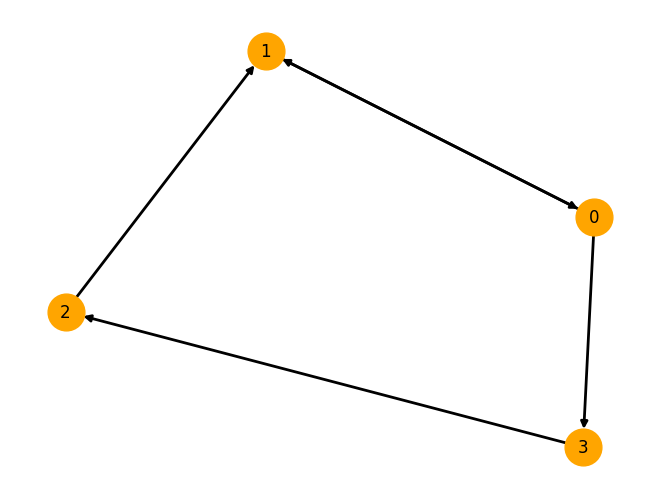

In [22]:
# Draw the graph
nx.draw(G, with_labels = True, node_color = "orange", width=2,node_size=700)

In [24]:
node_id = 0
# Degree of node 0: degree contains in_degree and out_degree
print("Node {} has degree {}".format(node_id, G.degree[node_id]))

# Get neighbor of node 0
for neighbor in G.neighbors(node_id):
    print("Node {} has neighbor {}".format(node_id, neighbor))

Node 0 has degree 3
Node 0 has neighbor 1
Node 0 has neighbor 3


In [25]:
# create a undirected graph
undirected_G = nx.Graph()

# add nodes in graph
undirected_G.add_nodes_from([0,1,2,3])

# add edges in graph
undirected_G.add_edges_from(adj_list)

In [26]:
print(f"Number of nodes: {undirected_G.number_of_nodes()}")
undirected_G.add_edge(3,4)
print(f"Number of nodes: {undirected_G.number_of_nodes()}")

Number of nodes: 4
Number of nodes: 5


In [27]:
undirected_G.edges()

EdgeView([(0, 1), (0, 3), (1, 2), (2, 3), (3, 4)])

In [28]:
node_id = 0

# Degree of node 0
print("Node {} has degree {}".format(node_id, undirected_G.degree[node_id]))

# Get neighbor of node 0
for neighbor in undirected_G.neighbors(node_id):
    print("Node {} has neighbor {}".format(node_id, neighbor))

Node 0 has degree 2
Node 0 has neighbor 1
Node 0 has neighbor 3


# PyTorch Geometric Tutorial

[PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) (PyG) is an extension library for PyTorch. 
It provides useful primitives to develop Graph Deep Learning models, including various graph neural network layers and a large number of benchmark datasets.

### Installation
You need to install PyG according to your **torch and cuda version**.

In [29]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

%pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Builit in dataset in PyG
Let's load a built in dataset to make sure PyG is installed successfully.

In [30]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [34]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [35]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
We can see that this `data` object holds 4 attributes:<br>
(1) The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge. <br>
(2) **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector)<br>
(3) **node labels** as `y` (each node is assigned to exactly one class).<br>
(4) There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathcal{E}$), or whether the graph is undirected (*i.e.*, for each edge $(v, w) \in \mathcal{E}$ there also exists the edge $(w, v) \in \mathcal{E}$).

Let us now inspect the `edge_index` property in more detail:

In [38]:
# take a look at first 10 edges
edge_index = data.edge_index
# print(edge_index[:10])
print(edge_index.t()[:10])

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11]])


By printing `edge_index`, we can understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

In [46]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

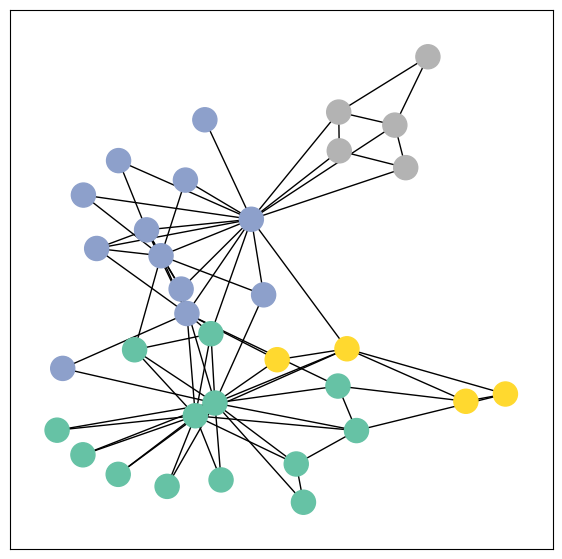

In [47]:
from torch_geometric.utils import to_networkx

# G = to_networkx(data, to_undirected=False)
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

Of course, PyG supports transforming networkx graph object into ```Data``` format

In [48]:
from torch_geometric.utils import from_networkx
# create a directed graph
directed = True
adj_list = [
    [0,1],
    [1,0],
    [2,1],
    [3,2],
    [0,3],
]

if directed:
    G = nx.DiGraph()
else:
    G = nx.Graph()

# add nodes in graph
G.add_nodes_from([0,1,2,3])

# add edges in graph
G.add_edges_from(adj_list)

pyg_Data = from_networkx(G)
print(pyg_Data)

Data(edge_index=[2, 5], num_nodes=4)


## Practice: graph analysis with networkx
In this practice, we will generate a random graph with `nx.erdos_renyi_graph` <br>
Please anwer the following questions:
1. How many nodes and edges are there in this graph?
2. The graph is directed or undirected?
3. What is the degree of node id 3, list all the neighbor nodes of node id 3.
4. Visualize the graph, is the graph dense or sparse?
5. Change `p` from **0.5** to **0.1**, what happens to the graph?
6. Convert the networkx graph `G` to PyG data format.


In [64]:
# generate a random graph
p = 0.2
G = nx.erdos_renyi_graph(50,p)

In [65]:
# please anser the questions above!
print(G.number_of_nodes())
print(G.number_of_edges())

50
275


In [66]:
nx.is_directed(G)

False

In [67]:
node_id = 3

# Degree of node 0
print(f"Node {node_id} has degree {G.degree(node_id)}")

# Get neighbor of node 0
for neighbor in G.neighbors(node_id):
    print("Node {} has neighbor {}".format(node_id, neighbor))

Node 3 has degree 14
Node 3 has neighbor 1
Node 3 has neighbor 7
Node 3 has neighbor 9
Node 3 has neighbor 18
Node 3 has neighbor 19
Node 3 has neighbor 21
Node 3 has neighbor 26
Node 3 has neighbor 27
Node 3 has neighbor 29
Node 3 has neighbor 30
Node 3 has neighbor 34
Node 3 has neighbor 41
Node 3 has neighbor 47
Node 3 has neighbor 49


In [68]:
len(G[3]), G[3]

(14,
 AtlasView({1: {}, 7: {}, 9: {}, 18: {}, 19: {}, 21: {}, 26: {}, 27: {}, 29: {}, 30: {}, 34: {}, 41: {}, 47: {}, 49: {}}))

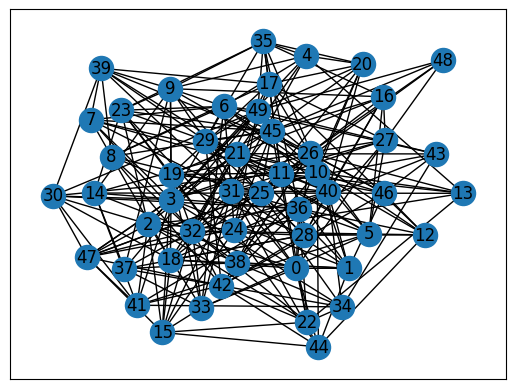

In [69]:
nx.draw_networkx(G)

In [70]:
data = from_networkx(G)

In [73]:
print(type(G))
print(type(data))

<class 'networkx.classes.graph.Graph'>
<class 'torch_geometric.data.data.Data'>
